In [1]:
import pyro
import pyro.distributions as dist
import torch
import matplotlib.pyplot as plt
from pyro.infer import MCMC, NUTS, HMC
from torch.distributions import MultivariateNormal
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
from utils.common import NeuralNet, fit
import seaborn as sns

/Users/jonas/opt/miniconda3/envs/DLSC/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_data = np.loadtxt("Data/TrainingData_Task4.txt", dtype=float)

t = training_data[:,0].reshape(-1,1)
u = training_data[:,1].reshape(-1,1)
T = training_data[:,2].reshape(-1,1)

train_in = np.concatenate((t, u), 1)
train_in = torch.tensor(train_in).type(torch.float32)
train_out = torch.tensor(T).type(torch.float32)

train_loader = DataLoader(torch.utils.data.TensorDataset(train_in, train_out), batch_size=len(train_in), shuffle=True)


In [3]:
# use max likelihood
# Model definition to learn the map network(t,u) = T_f
network = NeuralNet(input_dimension=2,
                  output_dimension=1,
                  n_hidden_layers=7,
                  neurons=40,
                  regularization_param=0,
                  regularization_exp=1,
                  retrain_seed=128)

# Predict network value of x
opt_type = "ADAM"
if opt_type == "ADAM":
    optimizer_cap = optim.Adam(network.parameters(), lr=0.001)

elif opt_type == "LBFGS":
    optimizer_cap = optim.LBFGS(network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)

else:
    raise ValueError("Optimizer not recognized")

n_epochs = 15000

history = fit(network, train_loader,n_epochs, optimizer_cap, p=2, verbose=False)

In [4]:
def G(inp):
    # Corresponds to G(x, w) from the notes, exact underlying model 
    # this might come from the solution of PDE, for example
    T = network(inp)
    return T

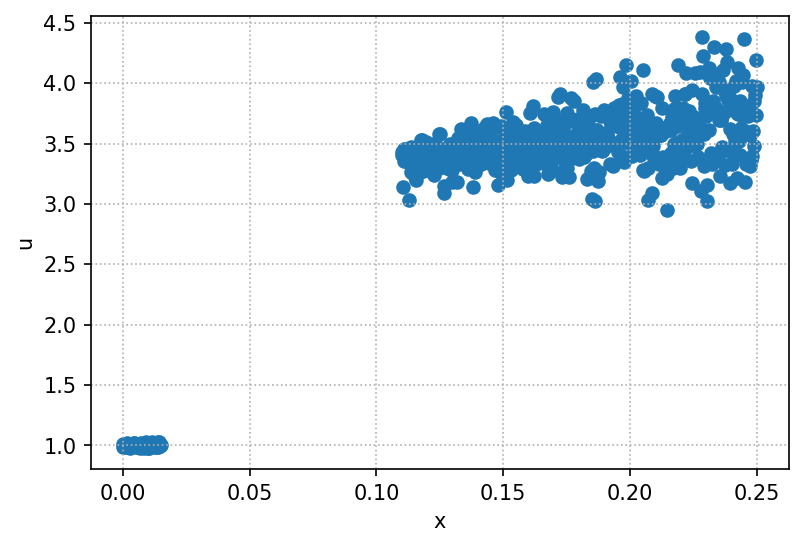

In [5]:
# Generate the data, we are going to infer w (compute its posterior) from these data
measured_data = np.loadtxt('Data/MeasuredData_Task4.txt')

measured_data_input = torch.from_numpy(measured_data[:,0].reshape(-1,1))
measured_data_output = torch.from_numpy(measured_data[:,1].reshape(-1,1))
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.scatter(measured_data_input, measured_data_output)
plt.xlabel("x")
plt.ylabel("u")
plt.show() 

In [6]:
# Define the prior and the likelihood according to pyro syntax
mu_prior = 12.
sigma_prior = 4
sigma_likelihood = 0.075

def model(x_observed, u_observed):
    # Prior is a gaussian distriubtion with mean 12 and standard deviation 4
    prior_w = dist.Normal(mu_prior, sigma_prior)
    
    # Sample from the prior
    w = pyro.sample("w", prior_w)
    w = w.expand(x_observed.shape[0], 1)
    # w = scale_u.transform(w.detach())
    #print(w)
    w = w.float()
    x_observed = x_observed.float()

    # Data likelihood is a gaussian distriubtion with mean G(x,w)=wx and standard deviation 0.075
    inputs = torch.cat([x_observed, w], 1)
    mean = G(inputs)
    likelihood = dist.Normal(mean, sigma_likelihood)
    
    # Sample from the likelihood
    u_sampled = pyro.sample("obs", likelihood, obs=u_observed)

In [7]:
n_samples = 10000
nuts_kernel = NUTS(model)
posterior = MCMC(nuts_kernel, num_samples=n_samples, warmup_steps=1000, initial_params={"w": torch.tensor(mu_prior)})
posterior.run(measured_data_input, measured_data_output)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in posterior.get_samples().items()}

Sample: 100%|██████████| 11000/11000 [01:56, 94.80it/s, step size=8.99e-01, acc. prob=0.947] 


/Users/jonas/opt/miniconda3/envs/DLSC/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Posterior Distrubtion')

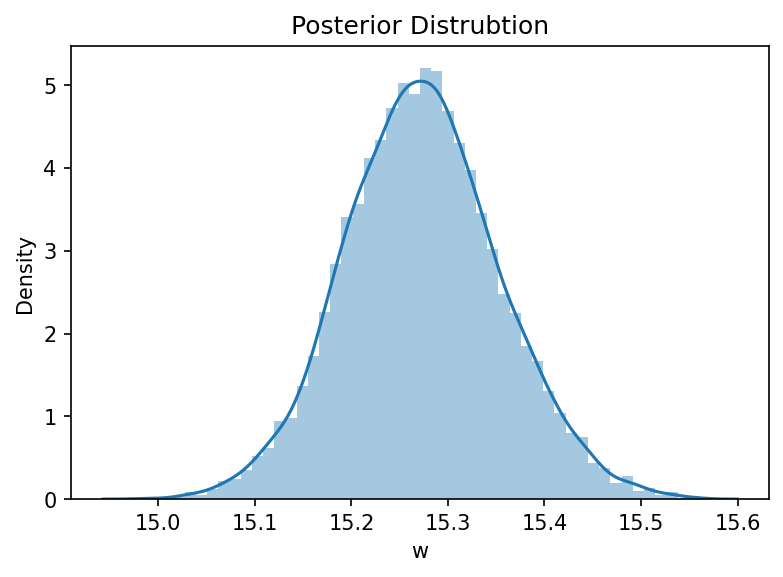

In [8]:
x_prior = np.random.normal(loc =mu_prior,scale=sigma_prior, size=1000)
plt.figure(dpi=150)
sns.distplot(hmc_samples["w"], label="Approximate", norm_hist=True)
# sns.distplot(exact_post_samples, label="Exact", norm_hist=True)
plt.xlabel("w")
plt.title("Posterior Distrubtion")
#np.savetxt('Task4c_Jonas.txt', hmc_samples['w'].reshape(-1,1))